# This is a guesser bot without any AI that plays higher or lower with itself to guess a number 

In [60]:
from typing import List, TypedDict
from langgraph.graph import StateGraph, END
import random

In [61]:
class AgentState(TypedDict):
    """ States of the graph """
    name : str
    guesses : list[int]
    low : int
    high : int
    target_number : int
    hint : str
    

In [72]:
def setup (state: AgentState) -> AgentState:
    """ setup function that assigns value to the basic variables"""
    state["name"] = f"Hi {state["name"]}, welcome! \n";
    state["target_number"] = random.randint(state["low"], state["high"]);
    state["hint"] = "I have chosen a random number \n";
    state["guesses"] = []
    print(f"Hi {state["name"]}, {state["hint"]} ")
    return state
    

In [78]:
def guess(state : AgentState) -> AgentState:
    "guesser node that makes a guess on the correct number"
    if state["hint"] == "lower":
        state["high"] = state["guesses"][-1];
    elif state["hint"] == "higher":
        state["low"] = state["guesses"][-1];
    
    state["guesses"].append(random.choice([i for i in range(state["low"], state["high"]+1) if i not in state["guesses"]]))
    print(f"Is it {state["guesses"][-1]} ? \n")
    return state

In [79]:
def hint(state : AgentState) -> AgentState:
    """ hint function to help the guesser node guess better """
    if(len(state["guesses"]) > 7):
        state["hint"] = f"Maximum number of guesses reached. The number was {state["target_number"]} \n";
        print(state["hint"])
        return state;
   
    if (state["guesses"][-1] == state["target_number"]):
        state["hint"] = f"Wow guessed in {len(state["guesses"])} attempts !, the number was {state["target_number"]} \n";
        print(state["hint"])
        return state;
  
    elif (state["guesses"][-1] > state["target_number"]):
        state["hint"] = f"lower";

  
    elif (state["guesses"][-1] < state["target_number"]):
        state["hint"] = f"higher";

    print(f"Incorrect. Guesses left : { 7 - len(state["guesses"])}, Hint: {state["hint"]}")
    return state;

def should_continue(state: AgentState) -> str:
    """Router function to determine next step"""
    if(len(state["guesses"]) > 7):
        return "end_game";
   
    if (state["guesses"][-1] == state["target_number"]):
        return "end_game";
    
    return "guess_again";

In [80]:
graph = StateGraph(AgentState)
graph.add_node("setup", setup);
graph.add_node("guess", guess);
graph.add_edge("setup", "guess");
graph.add_node("hint", hint);
graph.add_edge("guess", "hint")
graph.add_conditional_edges(
    "hint", 
    should_continue, 
    {
        "guess_again" : "guess", 
        "end_game" : END
    }
)

graph.set_entry_point("setup")
app = graph.compile()

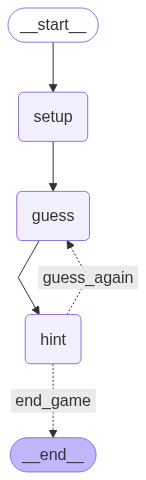

In [81]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [83]:
result = app.invoke(
    {
        "name" : "Kailash", 
        "low" : 1, 
        "high" : 20, 
        "guesses" : []
    }
)

Hi Hi Kailash, welcome! 
, I have chosen a random number 
 
Is it 18 ? 

Incorrect. Guesses left : 6, Hint: lower
Is it 4 ? 

Incorrect. Guesses left : 5, Hint: higher
Is it 11 ? 

Incorrect. Guesses left : 4, Hint: lower
Is it 8 ? 

Incorrect. Guesses left : 3, Hint: higher
Is it 10 ? 

Wow guessed in 5 attempts !, the number was 10 



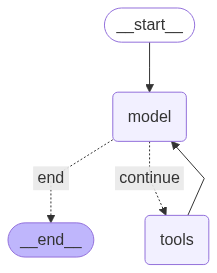

In [1]:
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, ToolMessage;
from langchain_google_genai import ChatGoogleGenerativeAI; # type: ignore
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from typing_extensions import Dict, TypedDict, Annotated, Sequence, Union;
from dotenv import load_dotenv;
load_dotenv()

class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage], add_messages]
    tower_1 : list[int]
    tower_2 : list[int]
    tower_3 : list[int]

# We'll create a custom tool node that has access to state
class StatefulToolNode:
    def __init__(self, tools):
        self.tools = {tool.name: tool for tool in tools}
    
    def __call__(self, state: AgentState):
        # Get the last message which should contain tool calls
        last_message = state["messages"][-1]
        tool_calls = last_message.tool_calls
        
        results = []
        for tool_call in tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            
            if tool_name in self.tools:
                # Pass the current state to the tool
                if tool_name == "move":
                    result = self.move_with_state(state, **tool_args)
                elif tool_name == "peek":
                    result = self.peek_with_state(state, **tool_args)
                elif tool_name == "get_all_towers":
                    result = self.get_all_towers_with_state(state)
                else:
                    result = f"Unknown tool: {tool_name}"
                
                results.append(ToolMessage(
                    content=result,
                    tool_call_id=tool_call["id"]
                ))
        
        return {"messages": results}
    
    def move_with_state(self, state: AgentState, source: str, destination: str) -> str:
        """Move a disk from source to destination tower with state validation"""
        # Validate tower names
        valid_towers = ["tower_1", "tower_2", "tower_3"]
        if source not in valid_towers or destination not in valid_towers:
            return f"Invalid tower name. Use tower_1, tower_2, or tower_3"
        
        # Check if source tower has disks
        if not state[source]:
            return f"Cannot move from {source}: tower is empty"
        
        # Get the top disk from source
        disk = state[source][-1]
        
        # Check if move is valid (can't place larger disk on smaller one)
        if state[destination] and state[destination][-1] < disk:
            return f"Invalid move: Cannot place disk {disk} on top of disk {state[destination][-1]}"
        
        # Perform the move by updating state
        moved_disk = state[source].pop()
        state[destination].append(moved_disk)
        
        return f"Moved disk {moved_disk} from {source} to {destination}. New state: tower_1={state['tower_1']}, tower_2={state['tower_2']}, tower_3={state['tower_3']}"
    
    def peek_with_state(self, state: AgentState, tower: str) -> str:
        """Check the current state of a tower"""
        valid_towers = ["tower_1", "tower_2", "tower_3"]
        if tower not in valid_towers:
            return f"Invalid tower name. Use tower_1, tower_2, or tower_3"
        
        if not state[tower]:
            return f"{tower} is empty"
        
        return f"{tower} contains disks: {state[tower]} (bottom to top)"
    
    def get_all_towers_with_state(self, state: AgentState) -> str:
        """Get the current state of all towers"""
        return f"Current game state - tower_1: {state['tower_1']}, tower_2: {state['tower_2']}, tower_3: {state['tower_3']}"

# Define tools for the LLM to understand available functions
@tool
def move(source: str, destination: str) -> str:
    """ Use this method to move a disk from one tower to another, mention the towers as \"tower_1\" or \"tower_2\" or \"tower_3\" """
    pass  # Implementation handled by StatefulToolNode

@tool
def peek(tower: str) -> str:
    """ You can see the current state of any tower simply parse the tower name as \"tower_1\" or \"tower_2\" or \"tower_3\" """
    pass  # Implementation handled by StatefulToolNode

@tool
def get_all_towers() -> str:
    """ Get the current state of all towers """
    pass  # Implementation handled by StatefulToolNode

tools = [move, peek, get_all_towers]

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash").bind_tools(tools)

def model_call(state: AgentState) -> AgentState:
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

def should_continue(state: AgentState):
    messages = state["messages"];
    last_message = messages[-1];
    if not last_message.tool_calls:
        return "end";
    return "continue";

# Create our custom stateful tool node
stateful_tool_node = StatefulToolNode(tools)

graph = StateGraph(AgentState);
graph.add_node("model", model_call);
graph.add_node("tools", stateful_tool_node);
graph.add_conditional_edges(
    "model", 
    should_continue, 
    {
        "continue" : "tools", 
        "end" : END
    }, 
    
)
graph.add_edge("tools", "model");
graph.add_edge(START, "model");

app = graph.compile();
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))